condition 0, high resolution mode, 180 Hz at double disc chopper, smallest opening

In [1]:
cd /SNS/users/lj7/dv/sns-chops/resolution/CNCS/

/SNS/users/lj7/dv/sns-chops/resolution/CNCS


In [2]:
#Program to load Vanadium or empty Can powder files and perform a constant-Q cut along the middle Q to look at energy resolution and intensity.
import matplotlib.pyplot as plt
from mantid import plots
from mantid.simpleapi import Load, ConvertToMD, BinMD, ConvertUnits, Rebin
from matplotlib.colors import LogNorm
import os, glob, numpy as np
import mantid.simpleapi as msa
from mantid import mtd
import scipy

from mcni.utils import conversion as conv

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import subprocess as sp
import pickle as pkl

In [4]:
instrument = 'CNCS'
ipts = 20360

In [5]:
%matplotlib notebook

In [6]:
# ls /SNS/CNCS/IPTS-20360/nexus/

In [7]:
# ls /SNS/CNCS/IPTS-20360/shared/autoreduce/

In [8]:
# ls /SNS/CNCS/IPTS-20360/shared/autoreduce/inelastic/

In [9]:
# cat /SNS/CNCS/IPTS-20360/shared/autoreduce/reduce_CNCS_2018.05.27_08.30.31.py

In [10]:
RunNumbers=range(274470+20+20,274470+20+20+20)
print(RunNumbers)
IPTS=20360
rawdatadir = "/SNS/%s/IPTS-%s/nexus" % (instrument, ipts)
autoreducedir="/SNS/%s/IPTS-%s/shared/autoreduce/" % (instrument, ipts)

[274510, 274511, 274512, 274513, 274514, 274515, 274516, 274517, 274518, 274519, 274520, 274521, 274522, 274523, 274524, 274525, 274526, 274527, 274528, 274529]


# gather data
**This can be skipped the 2nd time running this notebook**

In [11]:
# RunParams['frequency'].value

In [12]:
# RunParams.keys()

In [13]:
RunNumbers[0]

274510

In [14]:
! find /SNS/CNCS/IPTS-20360/shared/autoreduce/ -name CNCS_274515*

/SNS/CNCS/IPTS-20360/shared/autoreduce/inelastic/Nd2O3/CNCS_274515_powder_300p1.nxspe
/SNS/CNCS/IPTS-20360/shared/autoreduce/reduction_log/CNCS_274515.nxs.h5.log


In [15]:
!mkdir -p V-analysis
outdir = 'V-analysis'

In [16]:
%matplotlib inline

In [17]:
%%time
data_table = {}

for RunNumber in RunNumbers:
    print (RunNumber)
    try:
        # get counts
        ws = msa.Load(os.path.join(rawdatadir, "%s_%s.nxs.h5" % (instrument, RunNumber)))
        counts = ws.getNumberEvents()
        # get other metadata
        w=msa.CreateSingleValuedWorkspace()
        msa.LoadNexusLogs(w,os.path.join(rawdatadir, "%s_%s.nxs.h5" % (instrument, RunNumber)))
        RunParams=w.getRun()
        Energy = RunParams["EnergyRequest"].getStatistics().mean
        # generate a nice 2D multi-dimensional workspace
        paths = sp.check_output("find %s -iname 'CNCS_%s_*.nxspe'" % (autoreducedir, RunNumber), shell=True).splitlines()
        print paths
        assert len(paths)==1, str(paths)
        path = paths[0]
        data = msa.LoadNXSPE(path)
        values=msa.ConvertToMDMinMaxLocal('data',QDimensions='|Q|', dEAnalysisMode='Direct')
        minQ,minE=values.MinValues
        maxQ,maxE=values.MaxValues
        
        md = msa.ConvertToMD(InputWorkspace=data, QDimensions='|Q|', dEAnalysisMode='Direct')
        sqw = msa.BinMD(InputWorkspace=md,
                    AlignedDim0='|Q|,'+str(minQ)+','+str(maxQ)+',100',
                    AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',250')

        fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
        c = ax.pcolormesh(sqw, vmin=0., vmax=np.median(sqw.getSignalArray())/2.)
        cbar=fig.colorbar(c)
        cbar.set_label('Intensity (arb. units)') #add text to colorbar
        ax.set_title('Run '+str(RunNumber)+',Ei='+str(Energy)+'meV')
        plt.savefig(os.path.join(outdir, 'iqe-%s.png' % RunNumber))
        plt.close()

        # generate a 1D multi-dimensional workspace
        sqw_line= msa.BinMD(
            InputWorkspace=md,
            #AlignedDim0='|Q|,' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +',1',
            AlignedDim0='|Q|,%s,%s,1' % ((minQ*2+maxQ)/3 , (minQ+2*maxQ)/3),
            AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',500')
        sqw_line_Hist=msa.ConvertMDHistoToMatrixWorkspace('sqw_line', Normalization='NumEventsNormalization')

        fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
        c = ax.errorbar(sqw_line_Hist,label='Data', fmt='o-', mfc='none')
        ax.legend()
        ax.set_title('Run '+str(RunNumber)+',Ei='+str(Energy)+'meV,|Q|=[' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +']' )
        plt.savefig(os.path.join(outdir, 'ie-%s.png' % RunNumber))
        plt.close()       
        
        xbb, y, Err = sqw_line_Hist.extractX(), sqw_line_Hist.extractY(), sqw_line_Hist.extractE()
        xbb.shape = y.shape = Err.shape = -1,
        x = (xbb[1:]+xbb[:-1])/2
        IE = x,y,Err

        RunParams2=data.getRun()
        Ei=RunParams2["Ei"].value
        Q=(minQ+maxQ)/3
        # array=[0,RunNumber, Energy, Ei, Chopper, round(Chopper1), round(Chopper2), round(Chopper3), Height, dHeight, Center, dCenter, Sigma, dSigma, Q]
        print("Run=",RunNumber,", Energy=",Energy,"meV")
        #print array
        chopper_freqs = [RunParams['SpeedRequest%s' % (i+1,)].value.mean() for i in range(5)]
        data_table[RunNumber] = [Energy, Ei] + chopper_freqs + [IE, Q, counts]
        
    except:
        raise
        print(RunNumber,": Errors, either file not in directory or some syntax, or fitting / plot errors")


274510
['/SNS/CNCS/IPTS-20360/shared/autoreduce/FluxRes/CNCS_274510_powder_300p1.nxspe']


/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mantid/plots/helperfunctions.py:160: RuntimeWarning: invalid value encountered in true_divide
  data /= nev
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


('Run=', 274510, ', Energy=', 81.74512, 'meV')
274511
['/SNS/CNCS/IPTS-20360/shared/autoreduce/FluxRes/CNCS_274511_powder_300p0.nxspe']
('Run=', 274511, ', Energy=', 36.3311644444, 'meV')
274512
['/SNS/CNCS/IPTS-20360/shared/autoreduce/FluxRes/CNCS_274512_powder_300p0.nxspe']
('Run=', 274512, ', Energy=', 20.43628, 'meV')
274513
['/SNS/CNCS/IPTS-20360/shared/autoreduce/FluxRes/CNCS_274513_powder_300p0.nxspe']
('Run=', 274513, ', Energy=', 13.0792192, 'meV')
274514
['/SNS/CNCS/IPTS-20360/shared/autoreduce/FluxRes/CNCS_274514_powder_300p1.nxspe']
('Run=', 274514, ', Energy=', 9.08279111111, 'meV')
274515
['/SNS/CNCS/IPTS-20360/shared/autoreduce/inelastic/Nd2O3/CNCS_274515_powder_300p1.nxspe']
('Run=', 274515, ', Energy=', 6.67307102041, 'meV')
274516
['/SNS/CNCS/IPTS-20360/shared/autoreduce/inelastic/Nd2O3/CNCS_274516_powder_300p1.nxspe']
('Run=', 274516, ', Energy=', 5.10907, 'meV')
274517
['/SNS/CNCS/IPTS-20360/shared/autoreduce/inelastic/Nd2O3/CNCS_274517_powder_300p1.nxspe']
('Run=',

In [39]:
# ls V-analysis/

## Save -- skip this if run 2nd time

In [41]:
# ls

In [18]:
# pkl.dump(data_table, open('V_Cali_Int_Res_HighRes_datatable_E500bins.pkl', 'w'))

# Load data from saved file

In [7]:
# data_table = pkl.load(open('./V_Cali_Int_Res_HighRes_datatable.pkl'))
data_table = pkl.load(open('./V_Cali_Int_Res_HighRes_datatable_E500bins.pkl'))

# Directly get FWHM using interpolation

In [19]:
len(data_table)

20

In [20]:
%%time
plot = False
rows = []
for RunNumber, record in data_table.items():
    Energy, Ei = record[:2]
    print Ei
    IE,  Q, counts = record[-3:]
    x,y,Err = IE
    # reject if data is too noisy
    rel_err = Err[ y == y.max() ]/y.max()
    if not np.isfinite(rel_err) or rel_err > 0.05:
        #continue
        pass
    
    x_interp = np.arange(-Ei/2, Ei/2, Ei/5000)
    y_interp2 = np.interp(x_interp, x,y)
    # y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic', bounds_error=False)(x_interp)

    # print Ei, Energy
    if plot:
        plt.figure()
        plt.plot(x, y, '+')
        plt.plot(x_interp, y_interp2, '-')
    ymax = np.nanmax(y_interp2)
    hm = ymax/2
    middle = x_interp[y_interp2>hm]
    if middle.size:
        FWHM = middle[-1]-middle[0]
    else:
        FWHM = -1.
    Height = ymax
    Sigma = FWHM/2.355
    freqs = record[2:2+5]
    row=[0,RunNumber, Energy, Ei] + freqs + [Height, FWHM, Sigma, Q, counts]
    rows.append(row)
    continue

0.8174512
0.741452335601
81.74512
36.3311644444
20.43628
13.0792192
9.08279111111
6.67307102041
5.10907
4.03679604938
3.2698048
2.70231801653
2.27069777778
1.93479573964
1.6682677551
1.45324657778
1.2772675
1.13142034602
1.00919901235
0.905763102493
CPU times: user 9.81 ms, sys: 2.37 ms, total: 12.2 ms
Wall time: 26.4 ms


/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater


In [21]:
np.savetxt(
    # "./V_Cali_Int_Res_HighRes.dat",    # 250 bins
    "./V_Cali_Int_Res_HighRes_E500bins.dat",
    rows,
    header='RunNumber Energy Ei Chopper1 Chopper2 Chopper3 Chopper41 Chopper42 Height FWHM Sigma Q counts'
)

# Inspect

In [18]:
%matplotlib notebook

## Intensity vs E

<IPython.core.display.Javascript object>


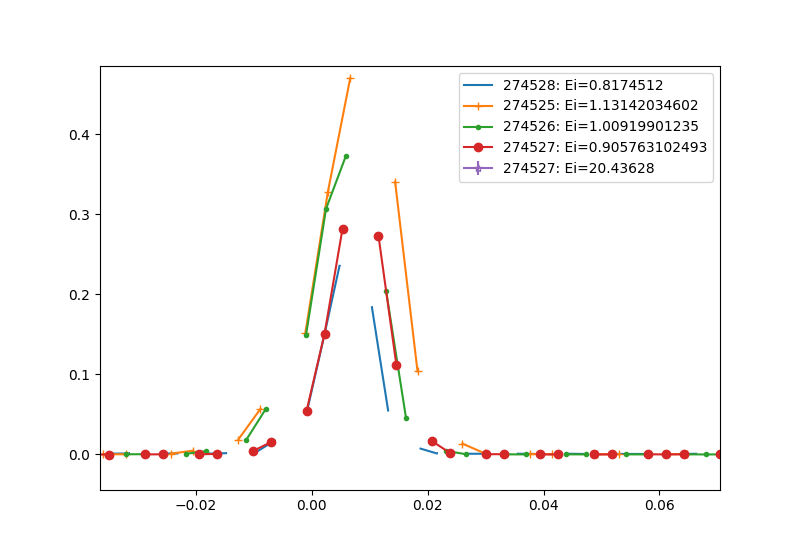

0.8174512
0.741452335601
81.74512
36.3311644444
20.43628
13.0792192
9.08279111111
6.67307102041
5.10907
4.03679604938
3.2698048
2.70231801653
2.27069777778
1.93479573964
1.6682677551
1.45324657778
1.2772675
1.13142034602
1.00919901235
0.905763102493


In [50]:
plt.figure(figsize=(8,5.5))

import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*', '^')) 

for RunNumber, record in data_table.items():
    Energy, Ei = record[:2]
    IE,  Q = record[-2:]
        
    print Energy
    if Energy>1.2 or Energy<0.8: continue
    x,y,Err = IE
    # scale = 1./y.max()
    scale = 1.
    y=y*scale; Err=Err*scale
    # x_interp = np.arange(-Ei/2, Ei/2, Ei/1000)
    # y_interp = np.interp(x_interp, x,y)
    # y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic', bounds_error=False)(x_interp)

    # print Ei, Energy
    # plt.plot(x, y/np.sum(y), label=Chopper2)
    # plt.errorbar(x,y, Err, fmt=marker.next()+'-', # mfc='none',
    #              label='%s: Ei=%s' % (RunNumber, Energy))
    plt.plot(x,y, marker.next()+'-', # mfc='none',
                 label='%s: Ei=%s' % (RunNumber, Energy))
    # plt.plot(x_interp, y_interp2, 'o')
# plt.xlim(-.3, .3)
plt.xlim(-.7, 1)
plt.legend()

## Intensity vs E/Ei

<IPython.core.display.Javascript object>


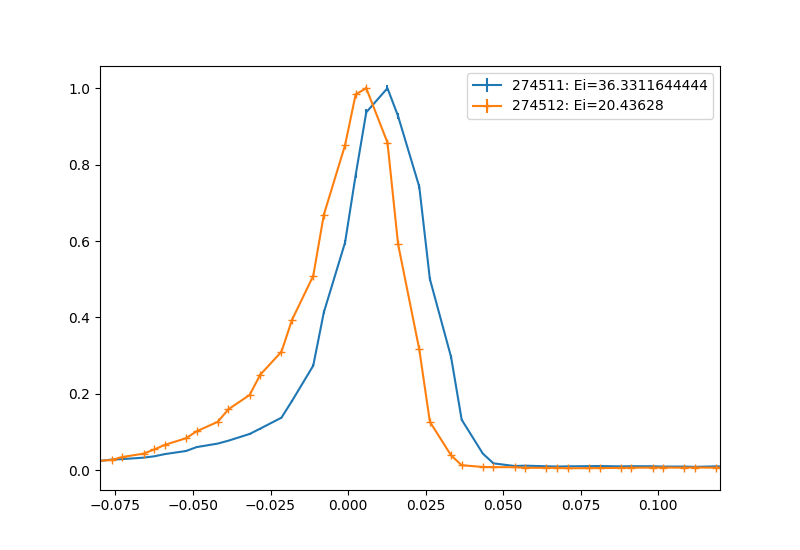

0.8174512
0.741452335601
81.74512
36.3311644444
20.43628
13.0792192
9.08279111111
6.67307102041
5.10907
4.03679604938
3.2698048
2.70231801653
2.27069777778
1.93479573964
1.6682677551
1.45324657778
1.2772675
1.13142034602
1.00919901235
0.905763102493


In [60]:
plt.figure(figsize=(8,5.5))

import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*', '^')) 

for RunNumber, record in data_table.items():
    Energy, Ei = record[:2]
    IE,  Q = record[-2:]
        
    print Energy
    if Energy<19 or Energy>40: continue
    x,y,Err = IE
    good = (x==x)*(y==y)*(Err==Err)
    x = x[good]; y = y[good]; Err = Err[good]
    scale = 1./y.max()
    # scale = 1.
    y=y*scale; Err=Err*scale
    x=x/Ei
    # x_interp = np.arange(-Ei/2, Ei/2, Ei/1000)
    # y_interp = np.interp(x_interp, x,y)
    # y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic', bounds_error=False)(x_interp)

    # print Ei, Energy
    # plt.plot(x, y/np.sum(y), label=Chopper2)
    plt.errorbar(x,y, Err, fmt='-'+marker.next(), mfc='none', label='%s: Ei=%s' % (RunNumber, Energy))
    # plt.plot(x_interp, y_interp2, 'o')
plt.xlim(-0.08, 0.12)
plt.legend()

# Ei =1  Q dependence

get I(E) for a series of Q values

In [70]:
%%time
IEs = {}  # Q dependent I(E) spectra
RunNumber = 274526
print (RunNumber)
w=msa.CreateSingleValuedWorkspace()
msa.LoadNexusLogs(w,os.path.join(rawdatadir, "%s_%s.nxs.h5" % (instrument, RunNumber)))
RunParams=w.getRun()
Energy = RunParams["EnergyRequest"].getStatistics().mean
# get path
paths = sp.check_output("find %s -iname 'CNCS_%s_*.nxspe'" % (autoreducedir, RunNumber), shell=True).splitlines()
print paths
assert len(paths)==1, str(paths)
path = paths[0]
# load data
data = msa.LoadNXSPE(path)
# get Q, E range
values=msa.ConvertToMDMinMaxLocal('data',QDimensions='|Q|', dEAnalysisMode='Direct')
minQ,minE=values.MinValues
maxQ,maxE=values.MaxValues
# convert to Q
md = msa.ConvertToMD(InputWorkspace=data, QDimensions='|Q|', dEAnalysisMode='Direct')

# get I(E)
Nstep = 10
Qstep = (maxQ-minQ)/Nstep
for Qcenter in np.arange(minQ+Qstep/2, maxQ, Qstep):
    sqw_line= msa.BinMD(
        InputWorkspace=md,
        #AlignedDim0='|Q|,' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +',1',
        AlignedDim0='|Q|,%s,%s,1' % (Qcenter-Qstep/2, Qcenter+Qstep/2),
        AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',500')
    sqw_line_Hist=msa.ConvertMDHistoToMatrixWorkspace('sqw_line', Normalization='NumEventsNormalization')
    xbb, y, Err = sqw_line_Hist.extractX(), sqw_line_Hist.extractY(), sqw_line_Hist.extractE()
    xbb.shape = y.shape = Err.shape = -1,
    x = (xbb[1:]+xbb[:-1])/2
    IE = x,y,Err
    IEs[Qcenter] = IE
    continue

274526
['/SNS/CNCS/IPTS-20360/shared/autoreduce/inelastic/Nd2O3/CNCS_274526_powder_300p1.nxspe']
CPU times: user 3.62 s, sys: 248 ms, total: 3.87 s
Wall time: 864 ms


In [69]:
#x,y,Err = IEs[-3]
#plt.figure()
#plt.errorbar(x,y,Err)

get FWHMs

In [88]:
%%time
plot = False
rows = []; totint = []
for Qc, IE in IEs.items():
    x,y,Err = IE
    # reject if data is too noisy
    rel_err = Err[ y == y.max() ]/y.max()
    if not np.isfinite(rel_err) or rel_err > 0.05:
        pass
        # continue
    
    x_interp = np.arange(-Ei/2, Ei/2, Ei/5000)
    y_interp2 = np.interp(x_interp, x,y)
    # y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic', bounds_error=False)(x_interp)

    # print Ei, Energy
    if plot:
        plt.figure()
        plt.plot(x, y, '+')
        plt.plot(x_interp, y_interp2, '-')
    ymax = np.nanmax(y_interp2)
    hm = ymax/2
    middle = x_interp[y_interp2>hm]
    if middle.size:
        FWHM = middle[-1]-middle[0]
    else:
        FWHM = -1.
    # print Qc, FWHM
    rows.append((Qc, FWHM))
    totint.append(y[y==y].sum())
    continue
Qs, FWHM_at_Q = np.array(rows).T

CPU times: user 3.92 ms, sys: 466 µs, total: 4.39 ms
Wall time: 3.25 ms


/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


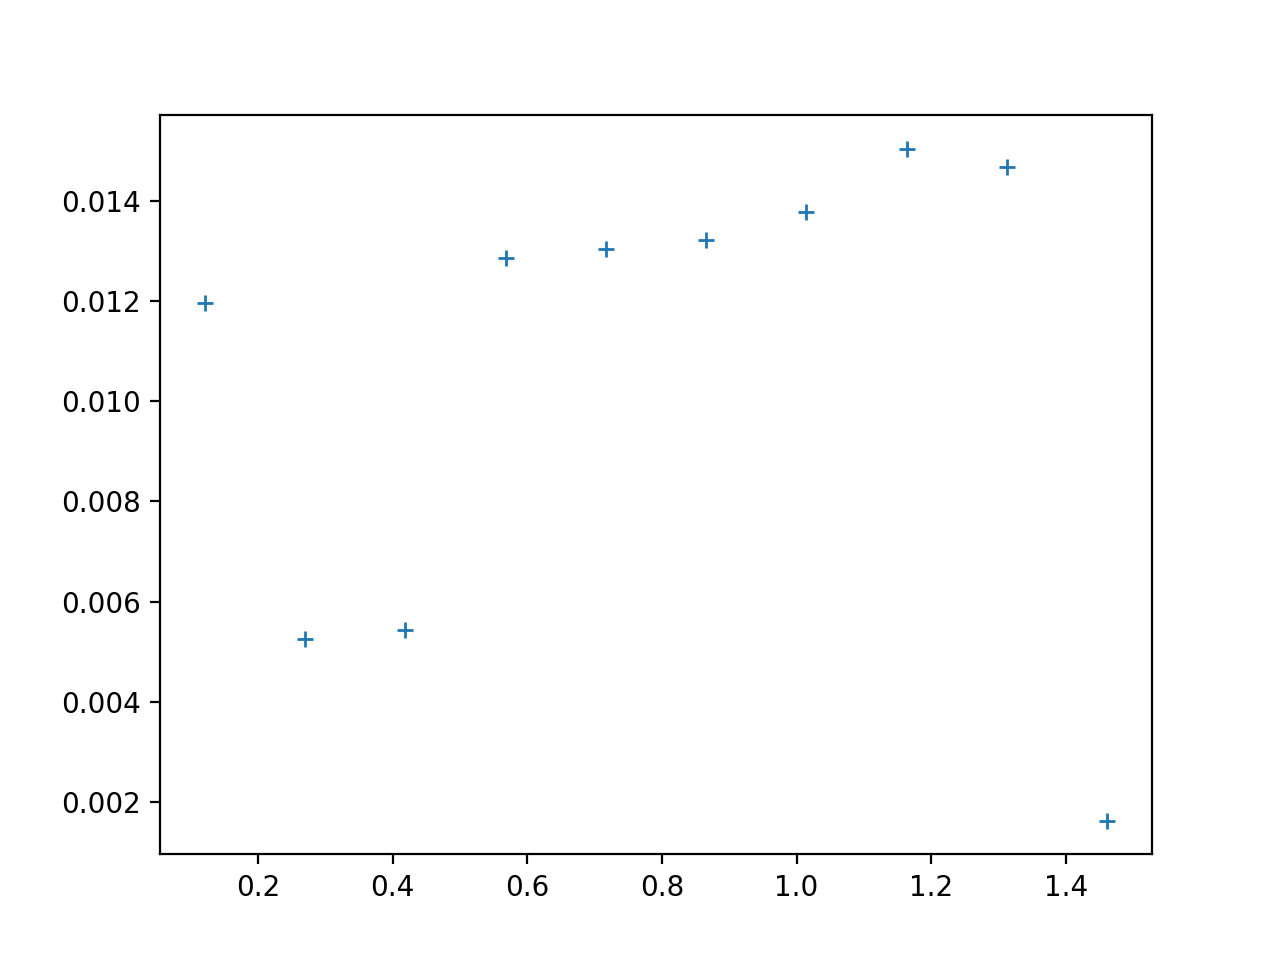

In [78]:
plt.figure()
plt.plot(Qs, FWHM_at_Q, '+')

use pychop to calculate FWHM

In [80]:
import sys
sys.path.insert(0, "/SNS/users/lj7/dv")

In [84]:
from PyChop import PyChop2
instrument = PyChop2('./PyChop/cncs.yaml')
instrument.setChopper('High Resolution')
sample_angles = np.arange(0, 180., 5.)
qs = []; fwhms = []
ki = kf = conv.e2k(1.)
for sa in sample_angles:
    instrument.detector.phi = sa
    q = np.sqrt(ki*ki+kf*kf - 2*ki*kf*np.cos(sa/180.*2*np.pi))
    qs.append(q)
    fwhms.append( instrument.getResFlux(Etrans=0, Ei_in=1., frequency=180.)[0][0] )

In [93]:
totint

[2.0452346551371825,
 1.0399057107137932,
 0.004228650087978237,
 1.2561880178395826,
 1.0891368164281663,
 1.0338493676807858,
 1.1383909715961946,
 1.2660549946597328,
 1.0400885606023773,
 1.2798362560370689]

<IPython.core.display.Javascript object>


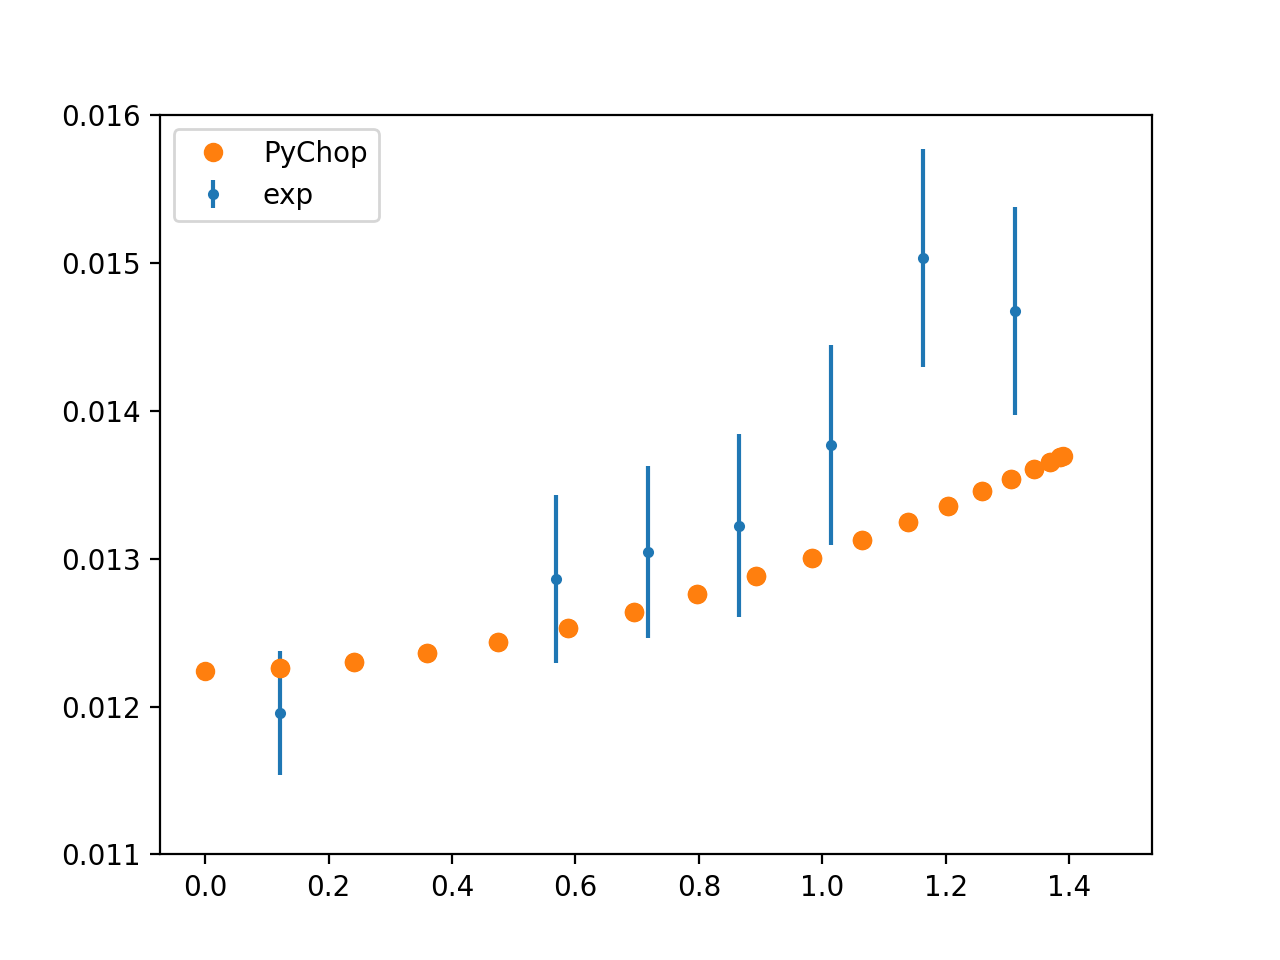

In [103]:
plt.figure()
plt.plot()
plt.errorbar(Qs, FWHM_at_Q, FWHM_at_Q / np.sqrt(totint)/20, fmt='.', label='exp')
plt.plot(qs, fwhms, 'o', label='PyChop')
plt.ylim(0.011, 0.016)
plt.legend(loc='upper left')

Sample size dependency

In [116]:
from PyChop import Chop
reload(Chop)

<module 'PyChop.Chop' from '/SNS/users/lj7/dv/PyChop/Chop.py'>

In [117]:
from PyChop import PyChop2
instrument = PyChop2('./PyChop/cncs.yaml')
instrument.setChopper('High Resolution')
sample_sizes = np.logspace(0, 2, 10)
fwhms = []
for ss in sample_sizes:
    instrument.sample.sy = ss
    fwhms.append( instrument.getResFlux(Etrans=0, Ei_in=1., frequency=180.)[0][0] )

<IPython.core.display.Javascript object>


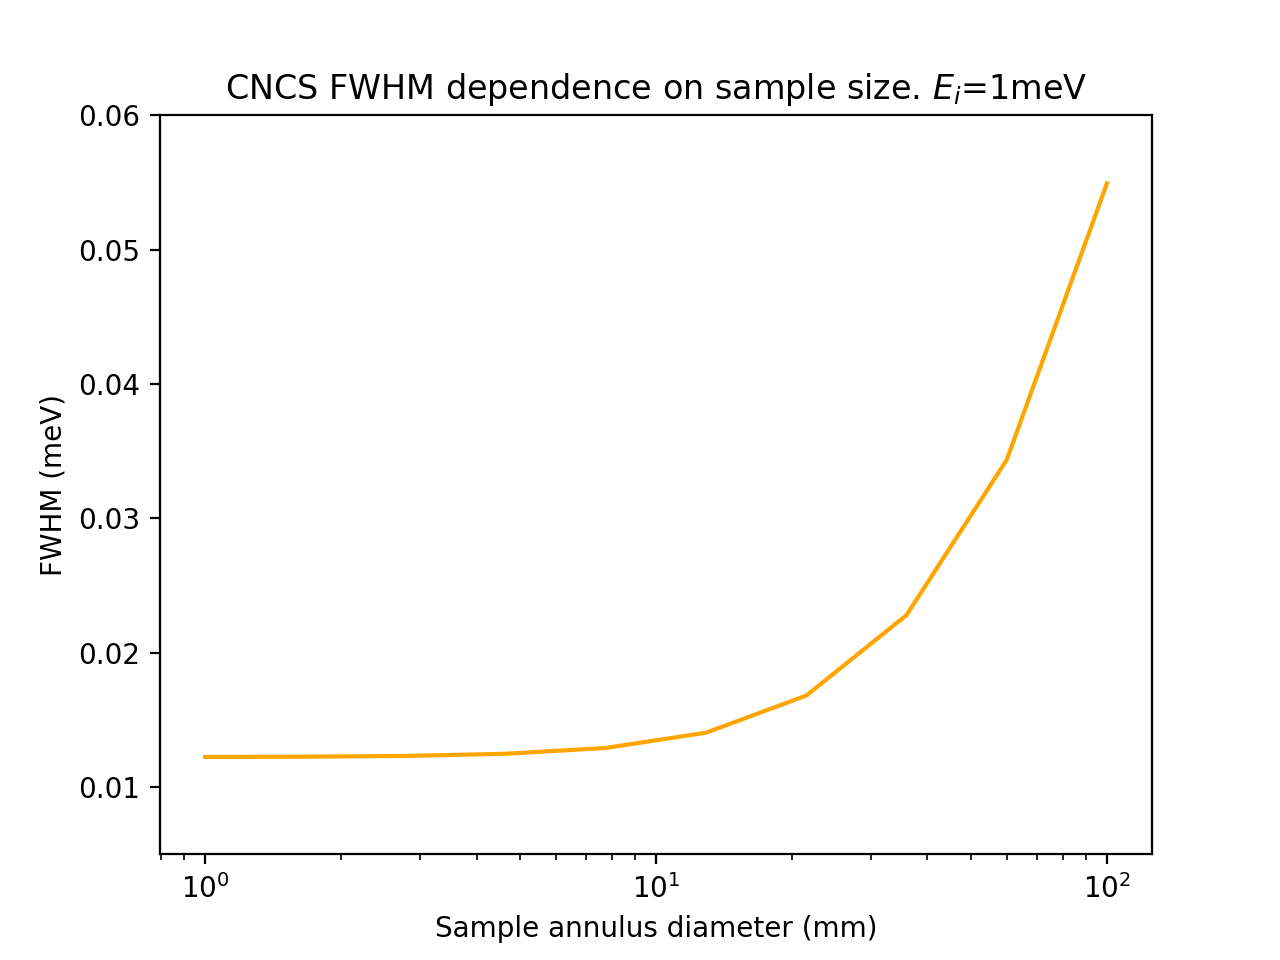

Text(0.5,1,u'CNCS FWHM dependence on sample size. $E_i$=1meV')

In [120]:
plt.figure()
plt.semilogx(sample_sizes, fwhms, color='orange')
plt.xlabel('Sample annulus diameter (mm)')
plt.ylabel('FWHM (meV)')
plt.ylim(0.005, 0.06)
plt.title('CNCS FWHM dependence on sample size. $E_i$=1meV')

# Ei=20

20.43628


<IPython.core.display.Javascript object>


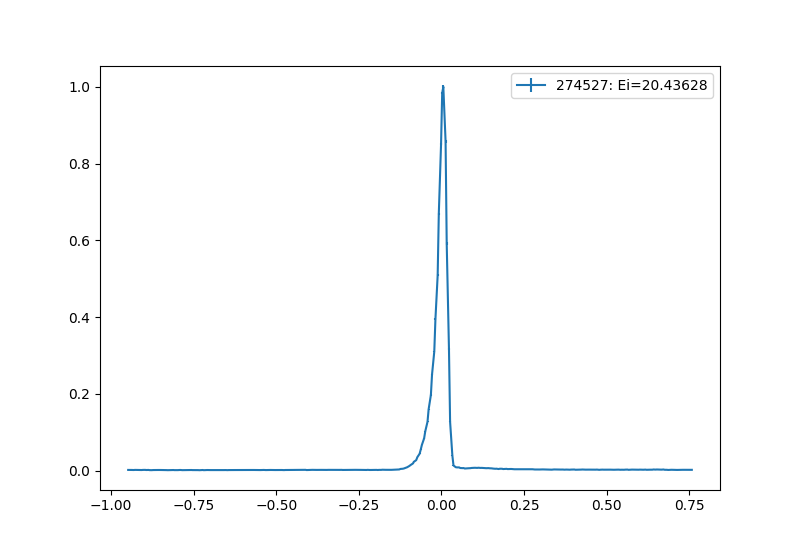

In [59]:
record = data_table[274512]
Energy, Ei = record[:2]
IE,  Q = record[-2:]
print Energy
x,y,Err = IE
good = (x==x)*(y==y)*(Err==Err)
x = x[good]; y = y[good]; Err = Err[good]
scale = 1./y.max()
# scale = 1.
y=y*scale; Err=Err*scale
x=x/Ei
# x_interp = np.arange(-Ei/2, Ei/2, Ei/1000)
# y_interp = np.interp(x_interp, x,y)
# y_interp2 = scipy.interpolate.interp1d(x,y, kind='quadratic', bounds_error=False)(x_interp)

plt.figure(figsize=(8,5.5))
# print Ei, Energy
# plt.plot(x, y/np.sum(y), label=Chopper2)
plt.errorbar(x,y, Err, fmt='-'+marker.next(), mfc='none', label='%s: Ei=%s' % (RunNumber, Energy))
# plt.plot(x_interp, y_interp2, 'o')
# plt.xlim(-0.08, 0.12)
plt.legend()

# Debug

In [52]:
rawws = msa.LoadEventNexus('/SNS/CNCS/IPTS-%s/nexus/CNCS_%s.nxs.h5' % (ipts, RunNumber))

In [55]:
run = rawws.getRun()

In [66]:
for i in range(5):
    print run['SpeedRequest%s' % (i+1,)].value.mean()

60.0
60.0
60.0
180.0
180.0


In [16]:
[k for k in rawws.getRun().keys() if 'field' in k.lower()]

['BL18:SE:GaussMeter:ReadField', 'BL18:SE:MagneticField', 'GaussMeterField']

In [10]:
ws = msa.LoadNexus('/SNS/ARCS/IPTS-????/shared/autoreduce/CNCS_????.nxs')

In [11]:
r = ws.getRun()

In [ ]:
r.keys()